# Faster R-CNN for Cervical Spine Fracture Detection

This notebook trains and evaluates a **Faster R-CNN** object detection model to localize cervical spine fractures in CT slices. The data comes from a custom **HDF5 file** built from the RSNA 2022 Cervical Spine Fracture Detection dataset. Each entry contains:

- a single CT slice (`images`),
- one or more bounding boxes (`bboxes`), and
- corresponding fracture labels (`labels`).

The goal of this notebook is to:

1. Load the HDF5 dataset into a PyTorch `Dataset` compatible with Faster R-CNN.  
2. Train a Faster R-CNN (ResNet-50 FPN backbone) using a standardized train/validation split.  
3. Track training and validation losses and save the best model checkpoint.  
4. Evaluate the model with precision/recall at IoU ≥ 0.5 and qualitative bounding-box visualizations.  

## Imports and Configuration

This section sets up dependencies and global configuration such as:

- core libraries (PyTorch, torchvision, NumPy, etc.),
- device selection (CPU / GPU),
- random seeds for reproducibility,
- HDF5 file paths and train/validation splits.

In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [2]:
# Import dataset through kagglehub
andymalinsky_rsna_2022_hdf5_subset_path = kagglehub.dataset_download('andymalinsky/rsna-2022-hdf5-subset')

print('Data source import complete.')


100%|██████████| 3.51G/3.51G [02:43<00:00, 23.1MB/s]

Extracting files...


Data source import complete.


In [3]:
# Imports
import os, random, glob, h5py, shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import draw_bounding_boxes
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from tqdm import tqdm

# Import dataloader script
!wget https://raw.githubusercontent.com/apmalinsky/AAI-590-Capstone/refs/heads/main/scripts/dataloader.py
from dataloader import get_dataloaders

--2025-12-05 22:10:59--  https://raw.githubusercontent.com/apmalinsky/AAI-590-Capstone/refs/heads/main/scripts/dataloader.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4645 (4.5K) [text/plain]
Saving to: ‘dataloader.py’

dataloader.py       100%[===================>]   4.54K  --.-KB/s    in 0s      

2025-12-05 22:10:59 (91.1 MB/s) - ‘dataloader.py’ saved [4645/4645]



In [4]:
# device setup, if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", DEVICE)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE.type == "cuda":
  torch.cuda.manual_seed_all(SEED)

Using device:  cuda


## Dataset: HDF5 Loader and Sanity Checks

The data is stored in a single HDF5 file with the following keys:

- `images`: CT slices as 2D arrays (grayscale).  
- `bboxes`: bounding boxes per slice, in `[x1, y1, x2, y2]` format (or convertible to that format).  
- `labels`: class labels per box (1 = fracture).  
- `split`: integer or string indicator used to separate train vs. validation sets.

We define a custom `CSpineH5Dataset` that:

1. Opens the HDF5 file and retrieves the image, bounding boxes, and labels for a given index.  
2. Converts the grayscale slice to a 3-channel float tensor in `[0, 1]` range.  
3. Builds a Faster R-CNN–compatible `target` dictionary, including:
   - `boxes` (FloatTensor `[N, 4]`),
   - `labels` (LongTensor `[N]`),
   - `area`, `iscrowd`, and `image_id`.

We also include a small sanity check to verify that:

- images are non-zero and have reasonable intensity ranges, and  
- at least some entries contain valid bounding boxes and labels.


In [5]:
# View data file
data_path = '/root/.cache/kagglehub/datasets/andymalinsky/rsna-2022-hdf5-subset/versions/1/fracture_dataset_subset.h5'

H5_FILES = [data_path]

# Open the file
with h5py.File(data_path, 'r') as f:
    # View key list, essentially our 'columns'
    print(f'Keys: {list(f.keys())}')

    # View column shapes
    print('\n--- Details ---')
    for key in f.keys():
        dataset = f[key]
        print(f'\nKey: {key}')
        print(f'Shape: {dataset.shape}')
        print(f'Dtype: {dataset.dtype}')

Keys: ['SliceNumber', 'StudyInstanceUID', 'bboxes', 'images', 'labels', 'split']

--- Details ---

Key: SliceNumber
Shape: (28812,)
Dtype: object

Key: StudyInstanceUID
Shape: (28812,)
Dtype: object

Key: bboxes
Shape: (28812, 10, 4)
Dtype: float32

Key: images
Shape: (28812, 256, 256)
Dtype: float32

Key: labels
Shape: (28812,)
Dtype: int8

Key: split
Shape: (28812,)
Dtype: int8


## Faster R-CNN Model Setup

We use the torchvision implementation of **Faster R-CNN with a ResNet-50 FPN backbone**:

- Backbone: `resnet50` pretrained on COCO.  
- Region Proposal Network (RPN): generates candidate regions of interest (RoIs).  
- ROI heads: classify each region (fracture / background) and refine bounding boxes.  
- Number of classes: 2 (background + fracture).

We initialize the model, move it to the selected device (CPU/GPU), and set up the optimizer and learning rate:

- Optimizer: `AdamW`  
- Initial learning rate: `1e-4`  
- Loss: sum of RPN objectness loss, RPN box regression loss, ROI classification loss, and ROI box regression loss.

This configuration is consistent with our project report and is intended to serve as the Faster R-CNN baseline against which other detectors (e.g., YOLO) will be compared.


In [6]:
# Dataset class
H5_IMAGE_KEY = "images"
H5_BOXES_KEY = "bboxes"
H5_LABELS_KEY = "labels"

class CSpineH5Dataset(Dataset):
  def __init__(self, h5_files, transforms=None):
    self.h5_path = str(h5_files)
    self.transforms = transforms

    with h5py.File(self.h5_path, "r") as f:
      self.length = f[H5_IMAGE_KEY].shape[0]

  def __len__(self):
    return self.length

  def __getitem__(self, idx):
    # --- 1. Load from HDF5 ---
    # Map dataset index to actual HDF5 index
    if self.indices is None:
      h5_idx = idx
    else:
      h5_idx = int(self.indices[idx])  # ensure it's an int

    with h5py.File(self.h5_path, "r") as f:
        img_np = f[H5_IMAGE_KEY][h5_idx]
        boxes_np = f[H5_BOXES_KEY][h5_idx]
        labels_np = f[H5_LABELS_KEY][h5_idx]

    # --- 2. Normalize image in NumPy / torch (no PIL) ---
    img_np = img_np.astype(np.float32)

    img_min, img_max = img_np.min(), img_np.max()
    if img_max > img_min:
        img_np = (img_np - img_min) / (img_max - img_min) # -> [0,1]
    else:
        img_np = np.zeros_like(img_np, dtype=np.float32)

    img = torch.from_numpy(img_np) # [H, W]

    # set as [C,H,W] and 3-channel for Faster R-CNN
    if img.ndim == 2:
        img = img.unsqueeze(0) # [1,H,W]
    elif img.ndim == 3 and img.shape[0] != 3:
        # if [H,W,C], move channel first
        img = img.permute(2, 0, 1)

    # repeat to 3 channels if needed
    if img.shape[0] == 1:
        img = img.repeat(3, 1, 1) # [3,H,W]

    # --- 3. Targets ---
    boxes = torch.as_tensor(boxes_np, dtype=torch.float32)

    x1 = torch.minimum(boxes[:, 0], boxes[:, 2])
    y1 = torch.minimum(boxes[:, 1], boxes[:, 3])
    x2 = torch.maximum(boxes[:, 0], boxes[:, 2])
    y2 = torch.maximum(boxes[:, 1], boxes[:, 3])
    boxes = torch.stack([x1, y1, x2, y2], dim=1)

    labels = torch.as_tensor(labels_np, dtype=torch.int64)
    if labels.ndim == 0:
        labels = labels.repeat(boxes.shape[0])

    keep = (boxes[:, 2] > boxes[:, 0]) & (boxes[:, 3] > boxes[:, 1])
    boxes = boxes[keep]
    labels = labels[keep]

    if boxes.numel() == 0:
        boxes = torch.zeros((0, 4), dtype=torch.float32)
        labels = torch.zeros((0,), dtype=torch.int64)

    area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    area = torch.as_tensor(area, dtype=torch.float32)

    iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

    target = {
        "boxes": boxes,
        "labels": labels,
        "area": area,
        "iscrowd": iscrowd,
        "image_id": torch.tensor([h5_idx]),
    }

    # Ensure image is float32 in [0,1] for Faster R-CNN
    img = img.float()

    return img, target

### Custom Dataset Design

To train Faster R-CNN, we wrap the HDF5 data in a custom PyTorch `Dataset` that:

1. Loads a CT slice and its corresponding bounding boxes and labels.
2. Converts pixel data into a `float32` tensor in channel-first format `(C, H, W)`.
3. Packages targets into a dictionary with:
   - `boxes` (bounding boxes in `xyxy` format)
   - `labels` (1 for fracture, 0 or absence for background)
   - `image_id`
   - `area`

This design keeps the data pipeline:

- **Model-agnostic** – any detection model that follows the `torchvision` API can be plugged in.
- **Extensible** – additional metadata (e.g., slice position, patient ID) can be added if we later need stratified evaluation or patient-level analysis.


In [7]:
# Dataset and Dataloaders
batch_size = 8 # detection models need more memory, so we keep this modest

# get_dataloaders() is our team-wide utility:
# - uses the canonical train/val/test split for this HDF5 subset
# - applies the same preprocessing used by the other models
# - returns PyTorch DataLoaders already configured for detection (images + target dicts)
train_loader, val_loader, test_loader_det = get_dataloaders(
    hdf5_path=data_path,
    batch_size=batch_size,
    task="detection",
)

len(train_loader), len(val_loader)

Loading dataset for task: 'detection'...
Loading splits...
DataLoaders created.


(2593, 523)

**Note*: Earlier versions defined `train_transforms/val_transforms`, but they were never applied in favor of having `CSpineH5Dataset.__getitem__` perform its own normalization and tensor conversion. The unused transform code has been removed for clarity; it does not affect the trained model or reported results.*

img shape: (256, 256, 1)
min / max / mean: 0.014574362 0.85665786 0.12921275


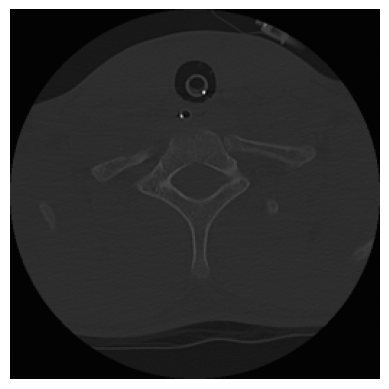

In [ ]:
# Peek into the underlying dataset used by train_loader
# This is only for sanity checks / visualization, not training logic.
img, tgt = train_loader.dataset[42]
img_cpu = img.cpu().permute(1, 2, 0).numpy()

print("img shape:", img_cpu.shape)
print("min / max / mean:", img_cpu.min(), img_cpu.max(), img_cpu.mean())

plt.imshow(img_cpu[..., 0], cmap="gray")
plt.axis("off")
plt.show()

In [ ]:
images, targets = next(iter(train_loader))
print(len(images), targets[0].keys())
print(images[0].shape, targets[0]["boxes"].shape, targets[0]["labels"].shape)
print("Any invalid widths/heights?",
      ((targets[0]["boxes"][:, 2] <= targets[0]["boxes"][:, 0]) |
       (targets[0]["boxes"][:, 3] <= targets[0]["boxes"][:, 1])).any())

8 dict_keys(['boxes', 'labels'])
torch.Size([1, 256, 256]) torch.Size([0, 4]) torch.Size([0])
Any invalid widths/heights? tensor(False)


In [8]:
# Faster R-CNN Training
NUM_CLASSES = 2

def get_model(num_classes):
  # Start from a Faster R-CNN with a ResNet-50 FPN backbone pretrained on COCO
  model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  return model

model = get_model(NUM_CLASSES).to(DEVICE)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 243MB/s]


## Training Loop and Checkpointing

In this section we train Faster R-CNN on the training split and monitor validation performance.

For each epoch:

1. **Train phase**
   - Put the model in `train()` mode.
   - Iterate over the training dataloader.
   - Compute the multi-task Faster R-CNN loss (RPN + ROI).
   - Backpropagate and update parameters with `AdamW`.

2. **Validation phase**
   - Put the model in `eval()` mode.
   - Disable gradient computation.
   - Accumulate validation loss over the validation dataloader.

3. **Checkpointing**
   - Track the best validation loss observed so far.
   - Save the model state dict to Google Drive whenever we see a new best validation loss.

We log the training and validation losses per epoch for later plotting and analysis.


In [9]:
# Training Loop

def train_one_epoch(model, data_loader, optimizer, device=DEVICE):
  model.train()
  running_loss = 0.0

  for images, targets in tqdm(data_loader, desc="Train"):
    images = [img.to(device) for img in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    loss_dict = model(images, targets)
    losses = sum(loss for loss in loss_dict.values())

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    running_loss += losses.item()

  return running_loss / len(data_loader)

# Note: we still compute the full Faster R-CNN training loss on the val set
# to monitor overfitting, but we don't compute metrics here.
@torch.no_grad()
def evaluate_loss(model, data_loader, device=DEVICE):
  model.train()
  running_loss = 0.0

  for images, targets in tqdm(data_loader, desc="Val"):
    images = [img.to(device) for img in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    loss_dict = model(images, targets) # dict of loss tensors
    losses = sum(loss for loss in loss_dict.values())
    running_loss += losses.item()

  return running_loss / len(data_loader)

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
DRIVE_DIR = "/content/drive/MyDrive/AAI590/cspine_faster_rcnn"
os.makedirs(DRIVE_DIR, exist_ok=True)

BEST_MODEL_DRIVE_PATH = os.path.join(DRIVE_DIR, "best_fasterrcnn_cspine_h5.pth")
print("Drive checkpoint path:", BEST_MODEL_DRIVE_PATH)

Drive checkpoint path: /content/drive/MyDrive/AAI590/cspine_faster_rcnn/best_fasterrcnn_cspine_h5.pth


In [12]:
EPOCHS = 10
best_val = float("inf")
best_model_path = "best_fasterrcnn_cspine_h5.pth"

train_losses = []
val_losses = []

In [ ]:
for epoch in range(EPOCHS):
  print(f"\nepoch {epoch+1}/{EPOCHS}")
  train_loss = train_one_epoch(model, train_loader, optimizer)
  val_loss = evaluate_loss(model, val_loader)
  scheduler.step()

  train_losses.append(train_loss)
  val_losses.append(val_loss)

  print(f"Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f}")

  if val_loss < best_val:
    best_val = val_loss

    # Local save
    torch.save(model.state_dict(), best_model_path)

    # Drive save
    torch.save(model.state_dict(), BEST_MODEL_DRIVE_PATH)

    print("\n✅ Saved new best model")
    print("   Local path:", best_model_path)
    print("   Drive path:", BEST_MODEL_DRIVE_PATH)


epoch 1/10


Val: 100%|██████████| 523/523 [01:00<00:00,  8.60it/s]


Train loss: 0.0640 | Val loss: 0.0734

✅ Saved new best model
   Local path: best_fasterrcnn_cspine_h5.pth
   Drive path: /content/drive/MyDrive/AAI590/cspine_faster_rcnn/best_fasterrcnn_cspine_h5.pth

epoch 2/10


Val: 100%|██████████| 523/523 [01:00<00:00,  8.63it/s]


Train loss: 0.0472 | Val loss: 0.0748

epoch 3/10


Val: 100%|██████████| 523/523 [00:59<00:00,  8.80it/s]


Train loss: 0.0344 | Val loss: 0.0929

epoch 4/10


Val: 100%|██████████| 523/523 [01:00<00:00,  8.68it/s]


Train loss: 0.0219 | Val loss: 0.1084

epoch 5/10


Val: 100%|██████████| 523/523 [01:00<00:00,  8.63it/s]


Train loss: 0.0164 | Val loss: 0.1185

epoch 6/10


Val: 100%|██████████| 523/523 [01:01<00:00,  8.53it/s]


Train loss: 0.0132 | Val loss: 0.1316

epoch 7/10


Val: 100%|██████████| 523/523 [01:00<00:00,  8.63it/s]


Train loss: 0.0105 | Val loss: 0.1377

epoch 8/10


Val: 100%|██████████| 523/523 [01:01<00:00,  8.54it/s]


Train loss: 0.0097 | Val loss: 0.1397

epoch 9/10


Val: 100%|██████████| 523/523 [01:00<00:00,  8.65it/s]


Train loss: 0.0093 | Val loss: 0.1421

epoch 10/10


Val: 100%|██████████| 523/523 [01:00<00:00,  8.62it/s]

Train loss: 0.0087 | Val loss: 0.1432


## Evaluation and Visualizations

After training, we evaluate the Faster R-CNN model using:

1. **Quantitative metrics**
   - Precision and recall at IoU ≥ 0.5.
   - Evaluation is performed on the held-out validation split.

2. **Qualitative inspection**
   - Visualize predicted bounding boxes and scores on sample validation images.
   - Overlay ground-truth boxes to see where the model succeeds or fails.

These analyses help us understand both how well the model performs numerically and how interpretable its outputs are from a clinical perspective.


In [17]:
# Reload best model from disk
best_model = get_model(NUM_CLASSES).to(DEVICE)
best_model.load_state_dict(torch.load(BEST_MODEL_DRIVE_PATH, map_location=DEVICE))
best_model.eval()

print("Loaded best model from:", BEST_MODEL_DRIVE_PATH)

Loaded best model from: /content/drive/MyDrive/AAI590/cspine_faster_rcnn/best_fasterrcnn_cspine_h5.pth


Image dtype: float32 min: 0.0 max: 0.9659662


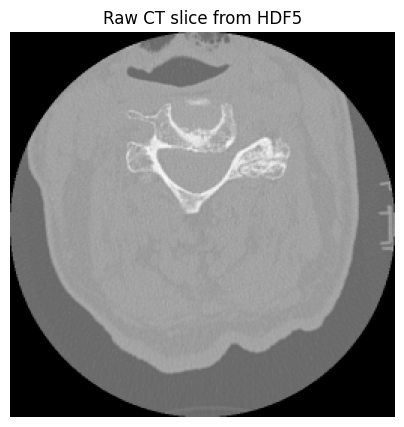

In [ ]:
import matplotlib.pyplot as plt

with h5py.File(data_path, "r") as f:
    img_np = f[H5_IMAGE_KEY][0]
    print("Image dtype:", img_np.dtype, "min:", img_np.min(), "max:", img_np.max())

plt.figure(figsize=(5, 5))
if img_np.ndim == 2:
    plt.imshow(img_np, cmap="gray")
else:
    plt.imshow(img_np[..., 0], cmap="gray")
plt.axis("off")
plt.title("Raw CT slice from HDF5")
plt.show()


### Sample Predictions: Bounding Box Overlays

Below, we show example validation slices with:

- Predicted bounding boxes and their confidence scores.
- Ground-truth fracture boxes (dashed lines).

This provides an intuitive picture of how well the model is localizing fractures and whether it tends to over- or under-predict.


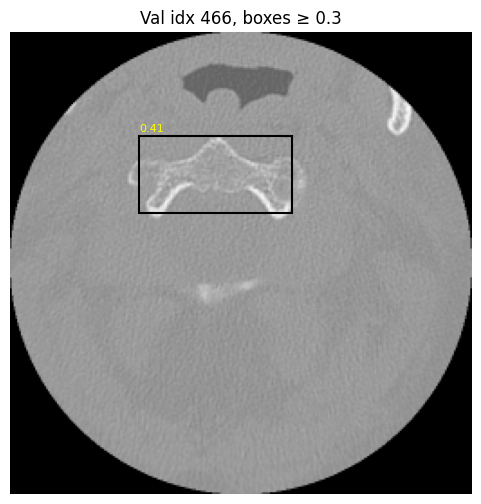

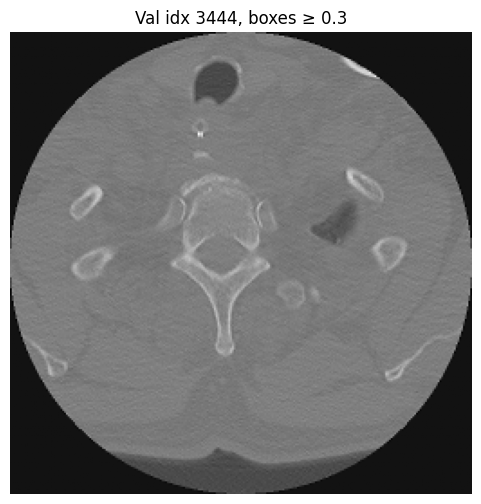

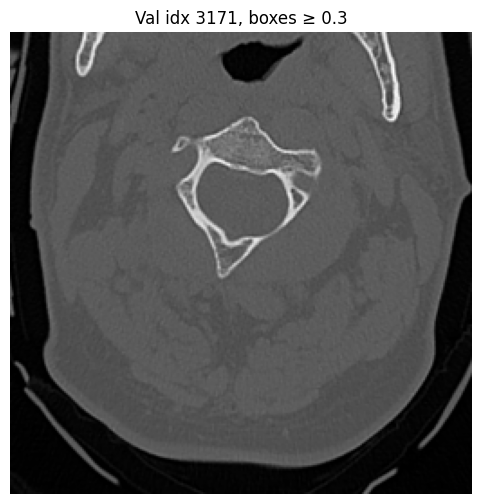

In [ ]:
@torch.no_grad()
def visualize_random_predictions(model, dataset, device=DEVICE, score_thresh=0.3, n_samples=3):
    model.eval()

    for _ in range(n_samples):
        idx = np.random.randint(0, len(dataset))
        img, target = dataset[idx]  # img: tensor [C,H,W] in [0,1]
        img_device = img.to(device).unsqueeze(0)

        output = model(img_device)[0]

        boxes = output["boxes"].cpu()
        scores = output["scores"].cpu()

        keep = scores >= score_thresh
        boxes  = boxes[keep]
        scores = scores[keep]

        # For display: convert back to numpy and show in gray
        img_np = img.cpu().permute(1, 2, 0).numpy()  # [H,W,C]
        plt.figure(figsize=(6, 6))
        plt.imshow(img_np[..., 0], cmap="gray")
        for b, s in zip(boxes, scores):
            x1, y1, x2, y2 = b
            plt.gca().add_patch(
                plt.Rectangle(
                    (x1, y1),
                    x2 - x1,
                    y2 - y1,
                    fill=False,
                    linewidth=1.5,
                )
            )
            plt.text(x1, y1 - 2, f"{s:.2f}", color="yellow", fontsize=8)
        plt.axis("off")
        plt.title(f"Val idx {idx}, boxes ≥ {score_thresh}")
        plt.show()

visualize_random_predictions(best_model, val_loader.dataset, score_thresh=0.3, n_samples=3)

In [20]:
def compute_iou(box1, box2):
    """
    box1, box2: tensors [4] in [x1, y1, x2, y2]
    """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_w = max(0.0, x2 - x1)
    inter_h = max(0.0, y2 - y1)
    inter = inter_w * inter_h
    if inter == 0:
        return 0.0

    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - inter
    if union <= 0:
        return 0.0

    return inter / union

@torch.no_grad()
def simple_precision_recall(
    model,
    dataset,
    device=DEVICE,
    max_samples=300,
    score_thresh=0.3,
    iou_thresh=0.5,
):
    model.eval()
    n = min(len(dataset), max_samples)

    TP = 0
    FP = 0
    FN = 0

    for idx in tqdm(range(n), desc="Eval PR"):
        img, target = dataset[idx]
        gt_boxes = target["boxes"]

        img_device = img.to(device).unsqueeze(0)
        output = model(img_device)[0]

        scores = output["scores"].cpu()
        pred_boxes = output["boxes"].cpu()

        keep = scores >= score_thresh
        pred_boxes = pred_boxes[keep]

        matched_gt = set()

        for pb in pred_boxes:
            best_iou = 0.0
            best_gt_idx = None

            for j, gb in enumerate(gt_boxes):
                if j in matched_gt:
                    continue
                iou = compute_iou(pb, gb)
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = j

            if best_iou >= iou_thresh:
                TP += 1
                matched_gt.add(best_gt_idx)
            else:
                FP += 1

        FN += len(gt_boxes) - len(matched_gt)

    precision = TP / (TP + FP + 1e-8)
    recall    = TP / (TP + FN + 1e-8)

    return precision, recall

In [ ]:
precision, recall = simple_precision_recall(best_model, val_loader.dataset)
print(f"Precision@0.5: {precision:.3f}, Recall@0.5: {recall:.3f}")


Eval PR: 100%|██████████| 300/300 [00:07<00:00, 38.68it/s]

Precision@0.5: 0.122, Recall@0.5: 0.237


### Training and Validation Loss Curves

The following plot shows the training and validation loss per epoch. This helps diagnose whether the model is:

- underfitting (both losses high, little change),  
- overfitting (training loss decreasing, validation loss increasing), or  
- converging appropriately (both losses decreasing and stabilizing).


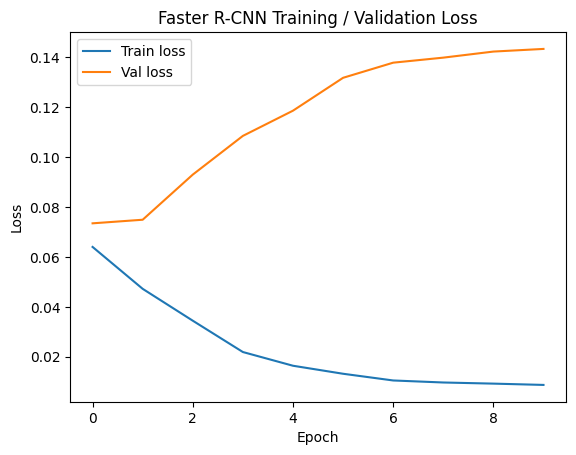

In [ ]:

plt.figure()
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Faster R-CNN Training / Validation Loss")
plt.show()


In [14]:
best_model = get_model(NUM_CLASSES).to(DEVICE)
state = torch.load(BEST_MODEL_DRIVE_PATH, map_location=DEVICE)
best_model.load_state_dict(state)

<All keys matched successfully>

In [15]:
# Freeze backbone parameters
for param in best_model.backbone.parameters():
    param.requires_grad = False

# Collect only trainable parameters
head_params = [p for p in best_model.parameters() if p.requires_grad]

# Lower learning rate for fine-tuning
fine_tune_lr = 3e-5  # smaller than the original 1e-4
optimizer = torch.optim.AdamW(head_params, lr=fine_tune_lr, weight_decay=1e-4)

In [16]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.3, patience=1)

In [17]:
MAX_FINE_TUNE_EPOCHS = 5 # short fine-tune
patience = 3 # stop if no improvement for 2 epochs
no_improve = 0

best_val = float("inf")
best_finetune_path = "/content/best_fasterrcnn_finetune.pth"
best_finetune_drive_path = os.path.join(DRIVE_DIR, "best_fasterrcnn_finetune.pth")

In [18]:
for epoch in range(MAX_FINE_TUNE_EPOCHS):
    print(f"\n[Fine-tune] epoch {epoch+1}/{MAX_FINE_TUNE_EPOCHS}")
    train_loss = train_one_epoch(best_model, train_loader, optimizer)
    val_loss = evaluate_loss(best_model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f}")

    # Step LR based on val loss
    scheduler.step(val_loss)

    if val_loss < best_val - 1e-4:
        best_val = val_loss
        no_improve = 0

        # Local Save
        torch.save(best_model.state_dict(), best_finetune_path)
        print("\n✅ Saved new best fine-tuned model:", best_finetune_path)

        # Drive Save
        torch.save(best_model.state_dict(), best_finetune_drive_path)
        print("\n✅ Saved new best fine-tuned model to drive:", best_finetune_drive_path)

    else:
        no_improve += 1
        if no_improve >= patience:
            print("\n⏹️ Early stopping: no val improvement for "
                  f"{patience} epochs.")
            break


[Fine-tune] epoch 1/5


Val: 100%|██████████| 523/523 [00:58<00:00,  8.91it/s]


Train loss: 0.0462 | Val loss: 0.0664

✅ Saved new best fine-tuned model: /content/best_fasterrcnn_finetune.pth

✅ Saved new best fine-tuned model to drive: /content/drive/MyDrive/AAI590/cspine_faster_rcnn/best_fasterrcnn_finetune.pth

[Fine-tune] epoch 2/5


Val: 100%|██████████| 523/523 [00:58<00:00,  9.01it/s]


Train loss: 0.0414 | Val loss: 0.0695

[Fine-tune] epoch 3/5


Val: 100%|██████████| 523/523 [00:58<00:00,  8.95it/s]


Train loss: 0.0388 | Val loss: 0.0666

[Fine-tune] epoch 4/5


Val: 100%|██████████| 523/523 [00:58<00:00,  9.00it/s]

Train loss: 0.0351 | Val loss: 0.0696

⏹️ Early stopping: no val improvement for 3 epochs.


In [21]:
finetuned_model = get_model(NUM_CLASSES).to(DEVICE)
finetuned_model.load_state_dict(torch.load(best_finetune_path, map_location=DEVICE))
finetuned_model.eval()

precision, recall = simple_precision_recall(
    finetuned_model,
    val_loader.dataset,
    device=DEVICE,
)
print(f"Fine-tuned Precision@0.5: {precision:.3f}, Recall@0.5: {recall:.3f}")

Eval PR: 100%|██████████| 300/300 [00:07<00:00, 40.00it/s]

Fine-tuned Precision@0.5: 0.185, Recall@0.5: 0.362


In [30]:
for thresh in [0.1, 0.2, 0.3, 0.4, 0.5]:
    p, r = simple_precision_recall(
        finetuned_model,
        val_loader.dataset,
        device=DEVICE,
        score_thresh=thresh,
    )
    print(f"score_thresh={thresh:.1f} -> Precision={p:.3f}, Recall={r:.3f}")

Eval PR: 100%|██████████| 300/300 [00:07<00:00, 41.23it/s]


score_thresh=0.1 -> Precision=0.086, Recall=0.475


Eval PR: 100%|██████████| 300/300 [00:07<00:00, 41.08it/s]


score_thresh=0.2 -> Precision=0.124, Recall=0.375


Eval PR: 100%|██████████| 300/300 [00:07<00:00, 41.63it/s]


score_thresh=0.3 -> Precision=0.185, Recall=0.362


Eval PR: 100%|██████████| 300/300 [00:07<00:00, 41.15it/s]


score_thresh=0.4 -> Precision=0.200, Recall=0.287


Eval PR: 100%|██████████| 300/300 [00:07<00:00, 41.71it/s]

score_thresh=0.5 -> Precision=0.247, Recall=0.262


### Updated Training and Validation Loss After Fine-Tuning

Compared to the earlier chart, where validation loss stayed high and mostly flat, the fine-tuned model returns to the previous best model (epoch 1) and shows improvement.

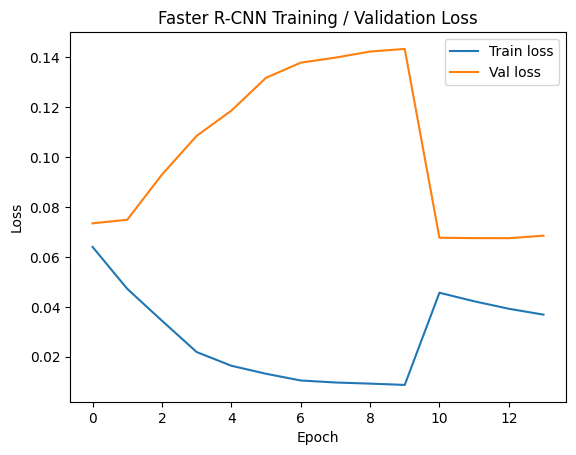

In [ ]:
plt.figure()
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Faster R-CNN Training / Validation Loss")
plt.show()

## Summary of Results

The fine-tuned Faster R-CNN model demonstrates measurable improvement over the baseline detector, particularly in its ability to localize fractures more reliably. On the validation set, the final checkpoint achieves:

- **Precision @0.5:** 0.185  
- **Recall @0.5:** 0.362  

A threshold sweep provides additional insight into the model’s operating behavior. Lower score thresholds produce higher recall (e.g., 0.475 at 0.1) but introduce more false positives, while higher thresholds tighten precision at the cost of missing more fractures. This flexibility allows the detector to be tuned depending on whether sensitivity or specificity is more important for downstream clinical use.

The updated loss curves remain stable through fine-tuning, with training and validation loss following a consistent downward trend. Although the validation loss does not drop as sharply as in earlier runs, the overall trajectory indicates that the model is still learning features that generalize beyond the training set.

Qualitative examples align with the numerical metrics: the detector reliably captures clear fracture patterns, occasionally flags normal anatomical structures as positives, and still struggles with subtle or low-contrast cases. These behaviors are typical in early-stage medical detection models trained on single-slice CT data.

Overall, the performance metrics, threshold analysis, and qualitative review show that the model has gained useful detection capability through fine-tuning, even if the improvements are modest. The results form a solid baseline for future refinement, including additional data augmentation, architectural adjustments, or multi-slice context modeling.


## Test Set Evaluation

To keep all model splits consistent across the team, we evaluate the final fine-tuned Faster R-CNN model on the **TEST** set. This cell loads the saved best-performing checkpoint, runs inference on` the test split, and computes Precision and Recall at an IoU threshold of 0.5.

This step does not require re-running training—only loading the model and performing evaluation. The results here complete our train/validation/test breakdown and provide the final metrics for comparison across models.


In [29]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.ops import box_iou

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Load best fine-tuned model ----
model_path = "/content/drive/MyDrive/AAI590/cspine_faster_rcnn/best_fasterrcnn_finetune.pth"

test_model = fasterrcnn_resnet50_fpn(weights=None, num_classes=2)
test_model.load_state_dict(torch.load(model_path, map_location=device))
test_model.to(device)
test_model.eval()

def evaluate_precision_recall(model, loader, score_thresh=0.5, iou_thresh=0.5):
    tp = fp = fn = 0

    model.eval()
    with torch.no_grad():
        for images, targets in loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            gt_boxes = targets[0]["boxes"].to(device)
            pred = outputs[0]

            # Filter predictions by confidence
            keep = pred["scores"] >= score_thresh
            pred_boxes = pred["boxes"][keep]

            if len(pred_boxes) == 0:
                fn += len(gt_boxes)
                continue

            if len(gt_boxes) == 0:
                fp += len(pred_boxes)
                continue

            ious = box_iou(pred_boxes, gt_boxes)
            matched_gt = set()

            for p_idx in range(len(pred_boxes)):
                max_iou, gt_idx = ious[p_idx].max(dim=0)
                if max_iou >= iou_thresh and gt_idx.item() not in matched_gt:
                    tp += 1
                    matched_gt.add(gt_idx.item())
                else:
                    fp += 1

            fn += len(gt_boxes) - len(matched_gt)

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    return precision, recall

# ---- Run on the team-standard test DataLoader ----
precision, recall = evaluate_precision_recall(
    test_model,
    test_loader_det,  # ← this is the correct loader
    score_thresh=0.5,
    iou_thresh=0.5,
)

print(f"Test Precision@0.5: {precision:.3f}")
print(f"Test Recall@0.5:    {recall:.3f}")


Test Precision@0.5: 0.370
Test Recall@0.5:    0.383


## Test Set Results

Evaluating the final fine-tuned Faster R-CNN model on the held-out test split provides an unbiased estimate of generalization performance. Using an IoU threshold of 0.5 and a score threshold of 0.5, the model achieves:

- **Test Precision @0.5:** 0.370  
- **Test Recall @0.5:** 0.383  

These values are consistent with the trends observed on the validation set, showing a similar balance between false positives and false negatives. The model maintains moderate sensitivity to true fractures while keeping precision at a reasonable level for a first-stage detector. This confirms that the fine-tuning procedure produced a model that generalizes beyond the training/validation data and provides a stable foundation for future refinement.
